<a href="https://colab.research.google.com/github/amey-raj/Image-Classifier/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 11.8 MB/s 
     |████████████████████████████████| 362 kB 64.8 MB/s 
     |████████████████████████████████| 1.2 MB 62.5 MB/s 
     |████████████████████████████████| 4.4 MB 39.4 MB/s 
     |████████████████████████████████| 1.1 MB 59.6 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 140 kB 85.7 MB/s 
     |████████████████████████████████| 212 kB 44.2 MB/s 
     |████████████████████████████████| 596 kB 66.0 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
     |████████████████████████████████| 271 kB 68.8 MB/s 
     |████████████████████████████████| 144 kB 68.7 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.1

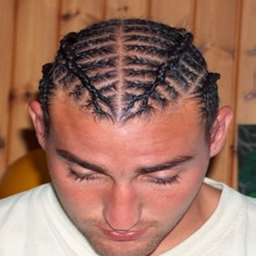

In [7]:
urls = search_images_ddg('cornrows men black', max_images=100)

download_url(urls[0], 'images/cornrows men black.jpg')
im = Image.open('images/cornrows men black.jpg')
im.thumbnail((256,256))
im

In [8]:
hair_types = 'cornrows men black', 'bald men black', 'fade men black'
path = Path("hair")

In [9]:
if not path.exists():
    path.mkdir()
    for o in hair_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg( f'{o} hair', max_images=100)
        download_images(dest, urls=results)

In [10]:
fns = get_image_files(path)
fns

(#294) [Path('hair/cornrows men black/00000066.jpg'),Path('hair/cornrows men black/00000088.jpg'),Path('hair/cornrows men black/00000089.jpg'),Path('hair/cornrows men black/00000025.jpg'),Path('hair/cornrows men black/00000051.jpg'),Path('hair/cornrows men black/00000052.jpg'),Path('hair/cornrows men black/00000009.jpg'),Path('hair/cornrows men black/00000040.jpg'),Path('hair/cornrows men black/00000021.jpg'),Path('hair/cornrows men black/00000076.jpg')...]

In [11]:
failed = verify_images(fns)
failed

# Delete damaged images #
failed.map(Path.unlink);


In [12]:
def parent_label_multi(o):
    return [Path(o).parent.name]

In [13]:
dblock = DataBlock(
    # blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi
    )

dsets = dblock.datasets(path)
dsets.train[0]

(Path('hair/bald men black/00000090.jpg'), ['bald men black'])

In [14]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(add_na=True)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi
    )

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=500x750, TensorMultiCategory([0., 1., 0., 0.]))

In [15]:
dsets.vocab

['#na#', 'bald men black', 'cornrows men black', 'fade men black']

In [16]:
x,y = dsets.train[0]
x.shape, y.shape

((750, 500), torch.Size([4]))

In [17]:
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

In [18]:
hair = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(add_na=True)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label_multi,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

dls = hair.dataloaders(path)

In [19]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 4]))

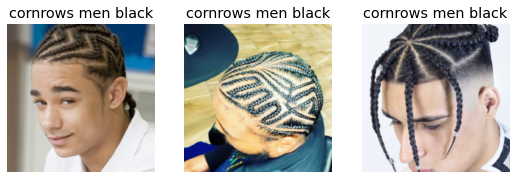

In [20]:
dls.train.show_batch(nrows=1, ncols=3)

In [21]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape, y.shape

(torch.Size([64, 4]), torch.Size([64, 4]))

In [23]:
activs[0]


TensorBase([ 0.9644, -0.9478,  1.5292,  0.2011], grad_fn=<AliasBackward0>)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy_multi,time
0,1.085489,1.020992,0.659483,00:48
1,0.976175,0.550853,0.875000,00:44
2,0.870708,0.391059,0.909483,00:43
3,0.783454,0.422723,0.896552,00:44


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.499601,0.424050,0.905172,00:55
1,0.451674,0.436377,0.900862,00:54
2,0.424831,0.414803,0.918103,00:54


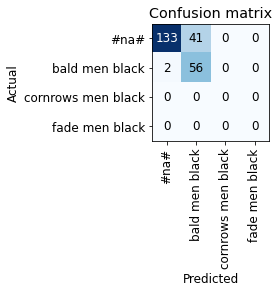

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,fade men black,bald men black,"TensorBase([0.4208, 0.9995, 0.0036, 0.0681])",2.69568133354187
1,fade men black,#na#;bald men black;fade men black,"TensorBase([6.5629e-01, 9.9590e-01, 9.6927e-04, 6.5891e-01])",1.7459149360656738
2,fade men black,#na#;bald men black;fade men black,"TensorBase([0.6526, 0.9912, 0.0013, 0.5681])",1.5898393392562866
3,fade men black,#na#;bald men black;fade men black,"TensorBase([0.8012, 0.9701, 0.0653, 0.6463])",1.4072318077087402
4,fade men black,bald men black;fade men black,"TensorBase([0.3156, 0.9660, 0.0042, 0.5296])",1.0999457836151123


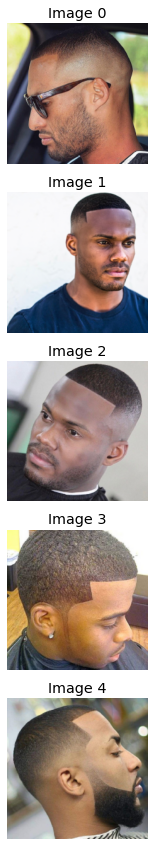

In [26]:
interp.plot_top_losses(5, nrows=5)


In [28]:
learn.export(fname="mullti_hair_classifier_second_at.pkl")